# Assistants 

[Assistants](https://langchain-ai.github.io/langgraph/concepts/assistants/#resources) give developers a quick and easy way to modify and version agents for experimentation.

## Supplying configuration to the graph

Our `task_maistro` graph is already set up to use assistants!

It has a `configuration.py` file defined and loaded into the graph.

We access configurable fields, such as the `user_id` and `todo_category`, inside the graph nodes.

## Creating assistants 

Now, what is a practical use-case for assistants with the `task_maistro` app that we've been building?

For me, it's the ability to have separate ToDo lists for different categories of tasks. 

For example, I want one assistant for my personal tasks and another for my work tasks.

This is very easily configurable using the `todo_category` configurable field.

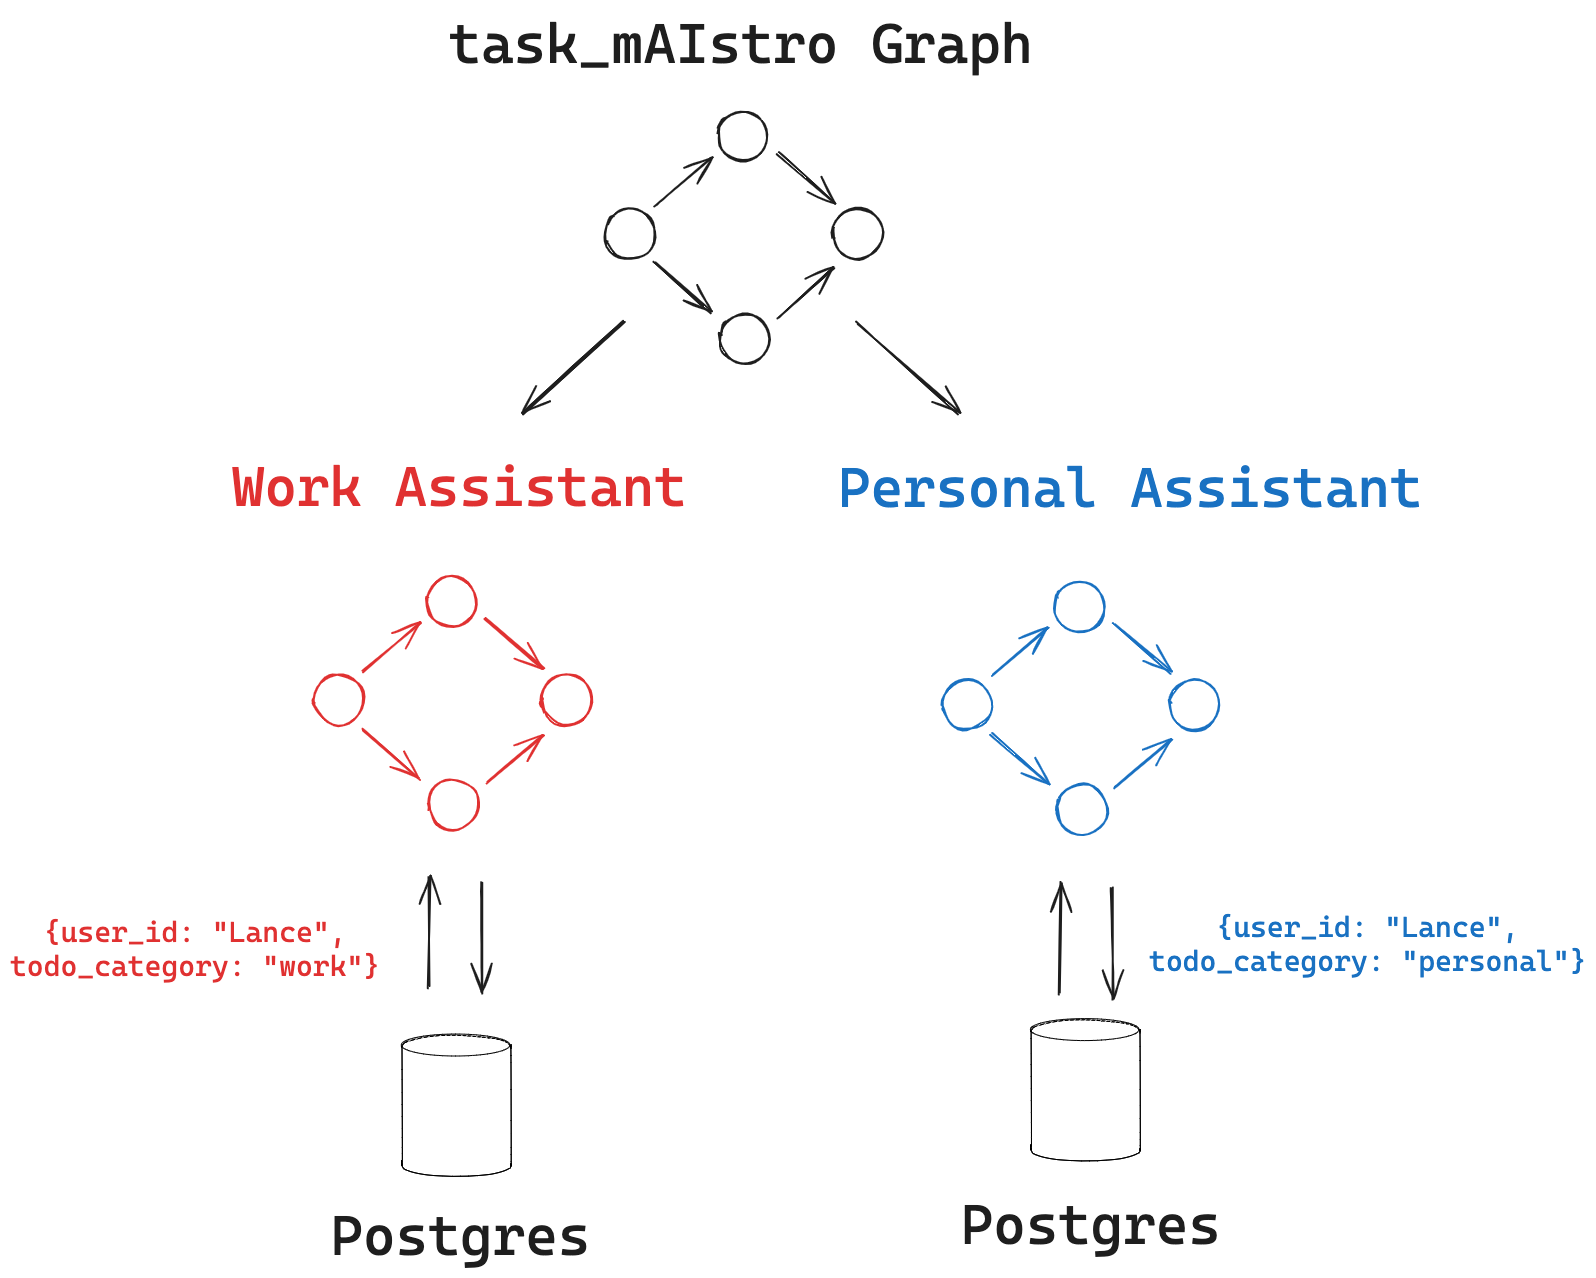

In [ ]:
%%capture --no-stderr
%pip install -U langgraph_sdk

This is the default assistant that we created when we deployed the graph.

In [2]:
from langgraph_sdk import get_client
url_for_cli_deployment = "http://localhost:8123"
client = get_client(url=url_for_cli_deployment)
assistants = await client.assistants.search()
assistants

[{'assistant_id': 'ea4ebafa-a81d-5063-a5fa-67c755d98a21',
  'graph_id': 'task_maistro',
  'created_at': '2024-11-08T21:51:08.277354+00:00',
  'updated_at': '2024-11-08T21:51:08.277354+00:00',
  'config': {},
  'metadata': {'created_by': 'system'},
  'version': 1,
  'name': 'task_maistro'}]

### Personal assistant

This is the personal assistant that I'll use to manage my personal tasks.

In [7]:
personal_assistant = await client.assistants.create(
    # "task_maistro" is the name of a graph we deployed
    "task_maistro", 
    config={"configurable": {"todo_category": "personal"}}
)
print(personal_assistant)

{'assistant_id': 'a7f91b04-96c9-41f5-b1fd-6df7f832eaf9', 'graph_id': 'task_maistro', 'created_at': '2024-11-14T00:11:39.510391+00:00', 'updated_at': '2024-11-14T00:11:39.510391+00:00', 'config': {'configurable': {'todo_category': 'personal'}}, 'metadata': {}, 'version': 1, 'name': 'Untitled'}


Let's update this assistant to include my `user_id` for convenience, [creating a new version of it](https://langchain-ai.github.io/langgraph/cloud/how-tos/assistant_versioning/#create-a-new-version-for-your-assistant). 

In [8]:
personal_assistant = await client.assistants.update(
    personal_assistant["assistant_id"],
    config={"configurable": {"todo_category": "personal", "user_id": "lance"}}
)
print(personal_assistant)

{'assistant_id': 'a7f91b04-96c9-41f5-b1fd-6df7f832eaf9', 'graph_id': 'task_maistro', 'created_at': '2024-11-14T00:12:15.676410+00:00', 'updated_at': '2024-11-14T00:12:15.676410+00:00', 'config': {'configurable': {'user_id': 'lance', 'todo_category': 'personal'}}, 'metadata': {}, 'version': 2, 'name': 'Untitled'}


### Work assistant

Now, let's create a work assistant. I'll use this for my work tasks.

In [9]:
work_assistant = await client.assistants.create(
    # "task_maistro" is the name of a graph we deployed
    "task_maistro", 
    config={"configurable": {"todo_category": "work"}}
)
print(work_assistant)

{'assistant_id': '1c6a3344-7e06-4ba9-b9cd-26e06f9650c8', 'graph_id': 'task_maistro', 'created_at': '2024-11-14T00:13:33.270702+00:00', 'updated_at': '2024-11-14T00:13:33.270702+00:00', 'config': {'configurable': {'todo_category': 'work'}}, 'metadata': {}, 'version': 1, 'name': 'Untitled'}


We can update it, too.

In [16]:
work_assistant = await client.assistants.update(
    work_assistant["assistant_id"],
    config={"configurable": {"todo_category": "work", "user_id": "lance"}}
)
print(work_assistant)

{'assistant_id': '1c6a3344-7e06-4ba9-b9cd-26e06f9650c8', 'graph_id': 'task_maistro', 'created_at': '2024-11-14T00:21:44.286366+00:00', 'updated_at': '2024-11-14T00:21:44.286366+00:00', 'config': {'configurable': {'user_id': 'lance', 'todo_category': 'work'}}, 'metadata': {}, 'version': 3, 'name': 'Untitled'}


## Using assistants 

Assistants will be saved to `Postgres` in our deployment.  

This allows us to easily search [search](https://langchain-ai.github.io/langgraph/cloud/how-tos/configuration_cloud/) for assistants with the SDK.

In [17]:
assistants = await client.assistants.search()
for assistant in assistants:
    print({
        'assistant_id': assistant['assistant_id'],
        'version': assistant['version'],
        'config': assistant['config']
    })

{'assistant_id': '1c6a3344-7e06-4ba9-b9cd-26e06f9650c8', 'version': 3, 'config': {'configurable': {'user_id': 'lance', 'todo_category': 'work'}}}
{'assistant_id': 'a7f91b04-96c9-41f5-b1fd-6df7f832eaf9', 'version': 2, 'config': {'configurable': {'user_id': 'lance', 'todo_category': 'personal'}}}
{'assistant_id': '83cd4d29-4a8e-4b57-9cd0-87b2bcc16596', 'version': 1, 'config': {'configurable': {'todo_category': 'work'}}}
{'assistant_id': 'f6e22d93-ce86-4915-b216-3e4bb7e97996', 'version': 1, 'config': {'configurable': {'todo_category': 'personal'}}}


We can manage them easily with the SDK. For example, we can delete assistants that we're no longer using.

In [13]:
await client.assistants.delete('assistant_id')

Let's set the assistant IDs for the `personal` and `work` assistants that I'll work with.

In [27]:
work_assistant_id = "1c6a3344-7e06-4ba9-b9cd-26e06f9650c8"
personal_assistant_id = "a7f91b04-96c9-41f5-b1fd-6df7f832eaf9"

We can run them. Let's add some ToDos for my work assistant.

In [24]:
from langchain_core.messages import HumanMessage
from langchain_core.messages import convert_to_messages

user_input = "Re-film module 6, lesson 1 tomorrow morning."
thread = await client.threads.create()
async for chunk in client.runs.stream(thread["thread_id"], 
                                      work_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

================================ Human Message =================================

Re-film module 6, lesson 1 tomorrow morning.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_JROElDsjcIt11ctilJrxNMh7)
 Call ID: call_JROElDsjcIt11ctilJrxNMh7
  Args:
    update_type: todo
================================= Tool Message =================================

Document f24448dc-a967-4f8f-9089-006b6712aab9 updated:
Plan: Update the deadline for the task 'Re-film module 6, lesson 1' to tomorrow morning, which is 2024-11-15T09:00:00.
Added content: 2024-11-15T09:00:00
================================== Ai Message ==================================

I've updated your ToDo list to re-film module 6, lesson 1 tomorrow morning. If there's anything else you need, just let me know!


Similarly, we can add ToDos for my personal assistant.

In [28]:
user_input = "Call back mom to plan Thanksgiving dinner."
thread = await client.threads.create()
async for chunk in client.runs.stream(thread["thread_id"], 
                                      personal_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

================================ Human Message =================================

Call back mom to plan Thanksgiving dinner.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_JROElDsjcIt11ctilJrxNMh7)
 Call ID: call_JROElDsjcIt11ctilJrxNMh7
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Call back mom to plan Thanksgiving dinner', 'time_to_complete': 30, 'deadline': '2024-11-20T18:00:00', 'solutions': ["Check mom's availability for a call", 'Prepare a list of potential dishes to discuss', 'Discuss guest list and any dietary restrictions', 'Decide on a time and place for the dinner'], 'status': 'not started'}
================================== Ai Message ==================================

I've added "Call back mom to plan Thanksgiving dinner" to your ToDo list. If there's anything else you need, just let me know!


These are quite nice because I don't need to worry about supplying the configuration when I run the graph! 

And I have my two assistants nicely seperated, with tasks for each one namespaced in the deployment Postgres database.